In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nsepy import get_history
%matplotlib inline
from datetime import date, timedelta, datetime

In [200]:
# Initialising the number of years of training data to be downloaded from NSE
training_no_of_years = 10
# Initialising start and end dates for stock data download
start_date = date.today() - timedelta(days = 365*training_no_of_years + training_no_of_years//4) #adjusting no of days for leap years in between
end_date = date.today()

In [201]:
# Stock selected is State Bank of India (NSE: SBIN), the largest bank in India and one of the most liquid stocks
stockdf = get_history(symbol = 'SBIN', start = start_date, end = end_date)

In [202]:
stockdf = stockdf.drop(['Trades', 'Turnover'], axis=1)

In [203]:
stockdf.head(3)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,
2009-11-18,SBIN,EQ,2350.75,2347.6,2358.95,2315.00,2325.0,2327.80,2338.23,1466296,335156,0.2286
2009-11-19,SBIN,EQ,2327.80,2329.0,2329.10,2270.05,2280.0,2281.35,2297.54,1690159,512171,0.3030
2009-11-20,SBIN,EQ,2281.35,2281.0,2346.00,2241.00,2339.0,2334.95,2288.01,2676013,884423,0.3305


In [204]:
stockdf.describe() # result shows that the stock data is not adjusted for a 1:10 split

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Deliverable Volume,%Deliverble
count,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2481.000000,2.481000e+03,2.481000e+03,2481.000000
mean,1253.764510,1254.476199,1270.538009,1237.069629,1252.673035,1252.953366,1254.053599,1.113081e+07,3.663065e+06,0.326997
std,1016.512222,1017.461172,1030.295346,1003.760629,1016.131037,1016.461550,1017.238975,1.372332e+07,4.835288e+06,0.101302
min,151.800000,155.000000,157.650000,148.250000,152.000000,151.800000,152.210000,8.841100e+04,1.799700e+04,0.084400
25%,273.000000,273.400000,276.550000,269.550000,273.000000,273.000000,272.870000,1.922217e+06,5.875300e+05,0.253300
50%,1500.550000,1499.900000,1515.000000,1471.100000,1496.900000,1497.850000,1498.270000,6.040815e+06,1.807521e+06,0.319500
75%,2212.300000,2210.000000,2239.650000,2176.100000,2208.200000,2210.550000,2211.140000,1.640838e+07,5.538257e+06,0.395000
max,3489.950000,3505.000000,3515.000000,3451.350000,3499.000000,3489.950000,3485.250000,2.626771e+08,1.333311e+08,0.716200


In [205]:
#Adjusting stock closing prices for splits of 1:10
stockdf['Close'] = stockdf['Close'].apply(lambda x:x/10 if x>1000 else x)

In [206]:
# Forming a 2-d array of closing prices to be fed into RNN
# We take the last 20 day prices in the test data (corresponding roughly to 1 calendar month)
trend_test_days = 20
training_set = stockdf.iloc[:len(stockdf)-trend_test_days,7:8].values

In [207]:
training_set, len(training_set)

(array([[232.78 ],
        [228.135],
        [233.495],
        ...,
        [258.45 ],
        [256.05 ],
        [265.45 ]]), 2461)

In [208]:
# Using normalisation to scale data, as RNN uses distance between data points to train 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [209]:
# The recurrent neural network with long short term memory (LSTM) will use a timestep of 120 trading days as memory
# Creating the data structure which preserves 120 days of memory
X_train = [] #initiate training lists
y_train = []
memory_range = 120
for i in range(memory_range, len(training_set_scaled)):
    X_train.append(training_set_scaled[(i - memory_range):i,0])
    y_train.append(training_set_scaled[i,0])

#Convert the lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [210]:
X_train.shape, y_train.shape

((2341, 120), (2341,))

In [211]:
# reshape the x_train array to fit the shape expected by RNN algorithm
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2341, 120, 1)

In [212]:
# Importing the RNN libraries and classes
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [213]:
#Initialise the regressor object of class Sequential
regressor = Sequential()

In [214]:
#Building the RNN architecture with dropout regularisation
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = False)) # last LSTM layer should have return sequence as False
regressor.add(Dropout(0.2))
#Adding the output layer
regressor.add(Dense(units = 1))

In [215]:
#Compile the recurrent neural network
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [216]:
#Fitting the RNN model on training data
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
2341/2341 [==============================] - 27s 11ms/step - loss: 0.0259
Epoch 2/100
2341/2341 [==============================] - 25s 11ms/step - loss: 0.0079
Epoch 3/100
2341/2341 [==============================] - 25s 11ms/step - loss: 0.0066
Epoch 4/100
2341/2341 [==============================] - 26s 11ms/step - loss: 0.0062
Epoch 5/100
2341/2341 [==============================] - 26s 11ms/step - loss: 0.0055
Epoch 6/100
2341/2341 [==============================] - 25s 11ms/step - loss: 0.0051
Epoch 7/100
2341/2341 [==============================] - 26s 11ms/step - loss: 0.0045
Epoch 8/100
2341/2341 [==============================] - 25s 11ms/step - loss: 0.0045
Epoch 9/100
2341/2341 [==============================] - 25s 11ms/step - loss: 0.0041
Epoch 10/100
2341/2341 [==============================] - 26s 11ms/step - loss: 0.0039
Epoch 11/100
2341/2341 [==============================] - 26s 11ms/step - loss: 0.0039
Epoch 12/100
2341/2341 [============================

2341/2341 [==============================] - 32s 14ms/step - loss: 0.0011
Epoch 96/100
2341/2341 [==============================] - 30s 13ms/step - loss: 0.0011
Epoch 97/100
2341/2341 [==============================] - 29s 12ms/step - loss: 0.0010
Epoch 98/100
2341/2341 [==============================] - 29s 12ms/step - loss: 0.0012
Epoch 99/100
2341/2341 [==============================] - 28s 12ms/step - loss: 0.0011
Epoch 100/100
2341/2341 [==============================] - 28s 12ms/step - loss: 0.0011


In [217]:
test_set = stockdf.iloc[len(stockdf) - memory_range - trend_test_days:,7:8].values
test_set = scaler.transform(test_set)
test_set.shape

(140, 1)

In [218]:
# preparing the test input data structure
X_test = []
for i in range(memory_range, memory_range + trend_test_days):
    X_test.append(test_set[i - memory_range:i, 0])
X_test = np.array(X_test)

In [219]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(20, 120, 1)

In [220]:
# Predict stock prices for the last 20 days
predicted_stock_prices = regressor.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

In [221]:
# Get actual stock prices for comparison of trend prediction
actual_stock_prices = stockdf.iloc[len(stockdf) - trend_test_days:,7:8].values
actual_stock_prices.shape, predicted_stock_prices.shape

((20, 1), (20, 1))

In [222]:
# Get data in dataframe format with added accuracy measures
final_stock_pred = pd.DataFrame(data = actual_stock_prices, columns = ['actual_stock_prices'])
final_stock_pred = pd.concat((final_stock_pred, pd.DataFrame(data = predicted_stock_prices, columns = ['predicted_stock_prices'])), axis=1)

In [223]:
final_stock_pred['actual_change'] = np.zeros(len(final_stock_pred))
final_stock_pred['predicted_change'] = np.zeros(len(final_stock_pred)) 

for i in range(0,len(final_stock_pred)-1):
    final_stock_pred['actual_change'][i+1] = ((final_stock_pred['actual_stock_prices'][i+1]) - (final_stock_pred['actual_stock_prices'][i]))/final_stock_pred['actual_stock_prices'].mean()
    final_stock_pred['predicted_change'][i+1] = ((final_stock_pred['predicted_stock_prices'][i+1]) - (final_stock_pred['predicted_stock_prices'][i]))/final_stock_pred['predicted_stock_prices'].mean()
    final_stock_pred['pred_accuracy'] = final_stock_pred['actual_change'] - final_stock_pred['predicted_change']

final_stock_pred['actual_change'] = (final_stock_pred['actual_change']*100).round(2)
final_stock_pred['predicted_change'] = (final_stock_pred['predicted_change']*100).round(2)
final_stock_pred['pred_accuracy'] = (final_stock_pred['pred_accuracy']*100).round(2)

C:\Users\8pros\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\8pros\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [234]:
final_stock_pred['%_price_diff'] = (((final_stock_pred['actual_stock_prices']-final_stock_pred['predicted_stock_prices'])/final_stock_pred['actual_stock_prices'].mean())*100).round(2)
print(final_stock_pred)
print('Average Prediction Accuracy: ',(final_stock_pred['pred_accuracy'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')
print('Average Price Difference between Actual & Predicted: ',(final_stock_pred['%_price_diff'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')

    actual_stock_prices  predicted_stock_prices  ...  pred_accuracy  %_price_diff
0                269.65              264.215607  ...           0.00          1.81
1                270.50              268.396118  ...          -1.13          0.70
2                275.45              269.336731  ...           1.33          2.04
3                262.50              274.375519  ...          -6.01         -3.96
4                281.55              262.769135  ...          10.26          6.26
5                281.80              280.961029  ...          -6.05          0.28
6                280.65              281.139771  ...          -0.44         -0.16
7                289.90              279.970551  ...           3.48          3.31
8                312.40              289.351074  ...           4.34          7.68
9                313.55              310.059570  ...          -6.60          1.16
10               314.30              311.468079  ...          -0.22          0.94
11              

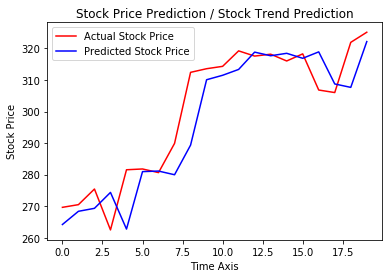

In [235]:
plt.plot(final_stock_pred['actual_stock_prices'], color = 'red', label = 'Actual Stock Price')
plt.plot(final_stock_pred['predicted_stock_prices'], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction / Stock Trend Prediction')
plt.xlabel('Time Axis')
plt.ylabel('Stock Price')
plt.legend()
plt.show()